
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [75]:
## library imports here
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import numpy as np

In [12]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha['sex'] = ha['sex'].astype(str)
ha['cp'] = ha['cp'].astype(str)
ha['restecg'] = ha['restecg'].astype(str)
ha['output'] = ha['output'].astype(str)

In [26]:
X = ha.drop(["cp"], axis = 1) # drop bc identification variables/response variable
y = ha["cp"]

# Split into test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


### KNN

In [15]:
# KNN
ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'), # do not predict new/unknown categories
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

knnPipeline = Pipeline(
  [("preprocessing", ct),
  ("knn_model", KNeighborsClassifier())]
)

# Find optimal n_neighbors based on roc_auc scoring
neighbors = {'knn_model__n_neighbors': np.arange(1, 50)}

gscv = GridSearchCV(knnPipeline, neighbors, cv = 5, scoring='accuracy')
gscv_fitted = gscv.fit(X, y)
pd.DataFrame(data = {"neighbors": np.arange(1, 50), "scores": gscv_fitted.cv_results_['mean_test_score']}).sort_values(by='scores', ascending=False).iloc[0]

neighbors    25.000000
scores        0.560471
Name: 24, dtype: float64

In [27]:
knnPipeline = Pipeline(
  [("preprocessing", ct),
  ("knn_model", KNeighborsClassifier(n_neighbors = 25))]
)

knn_model_fitted = knnPipeline.fit(X,y)

# accuracy 
knn_model_fitted.score(X_test, y_test)

0.5652173913043478

### Decision Tree

In [35]:
# Decision Tree
decisiontreePipeline = Pipeline(
  [("preprocessing", ct),
  ("decision_tree_model", DecisionTreeClassifier())]
)

# Find optimal min_samples_leaf based on roc_auc scoring
samples_leaf = {'decision_tree_model__min_samples_leaf': np.arange(5, 50)}

gscv = GridSearchCV(decisiontreePipeline, samples_leaf, cv = 5, scoring='accuracy')
gscv_fitted = gscv.fit(X, y)
pd.DataFrame(data = {"samples_leaf": np.arange(5, 50), "scores": gscv_fitted.cv_results_['mean_test_score']}).sort_values(by='scores', ascending=False).iloc[0]

samples_leaf    32.000000
scores           0.563973
Name: 27, dtype: float64

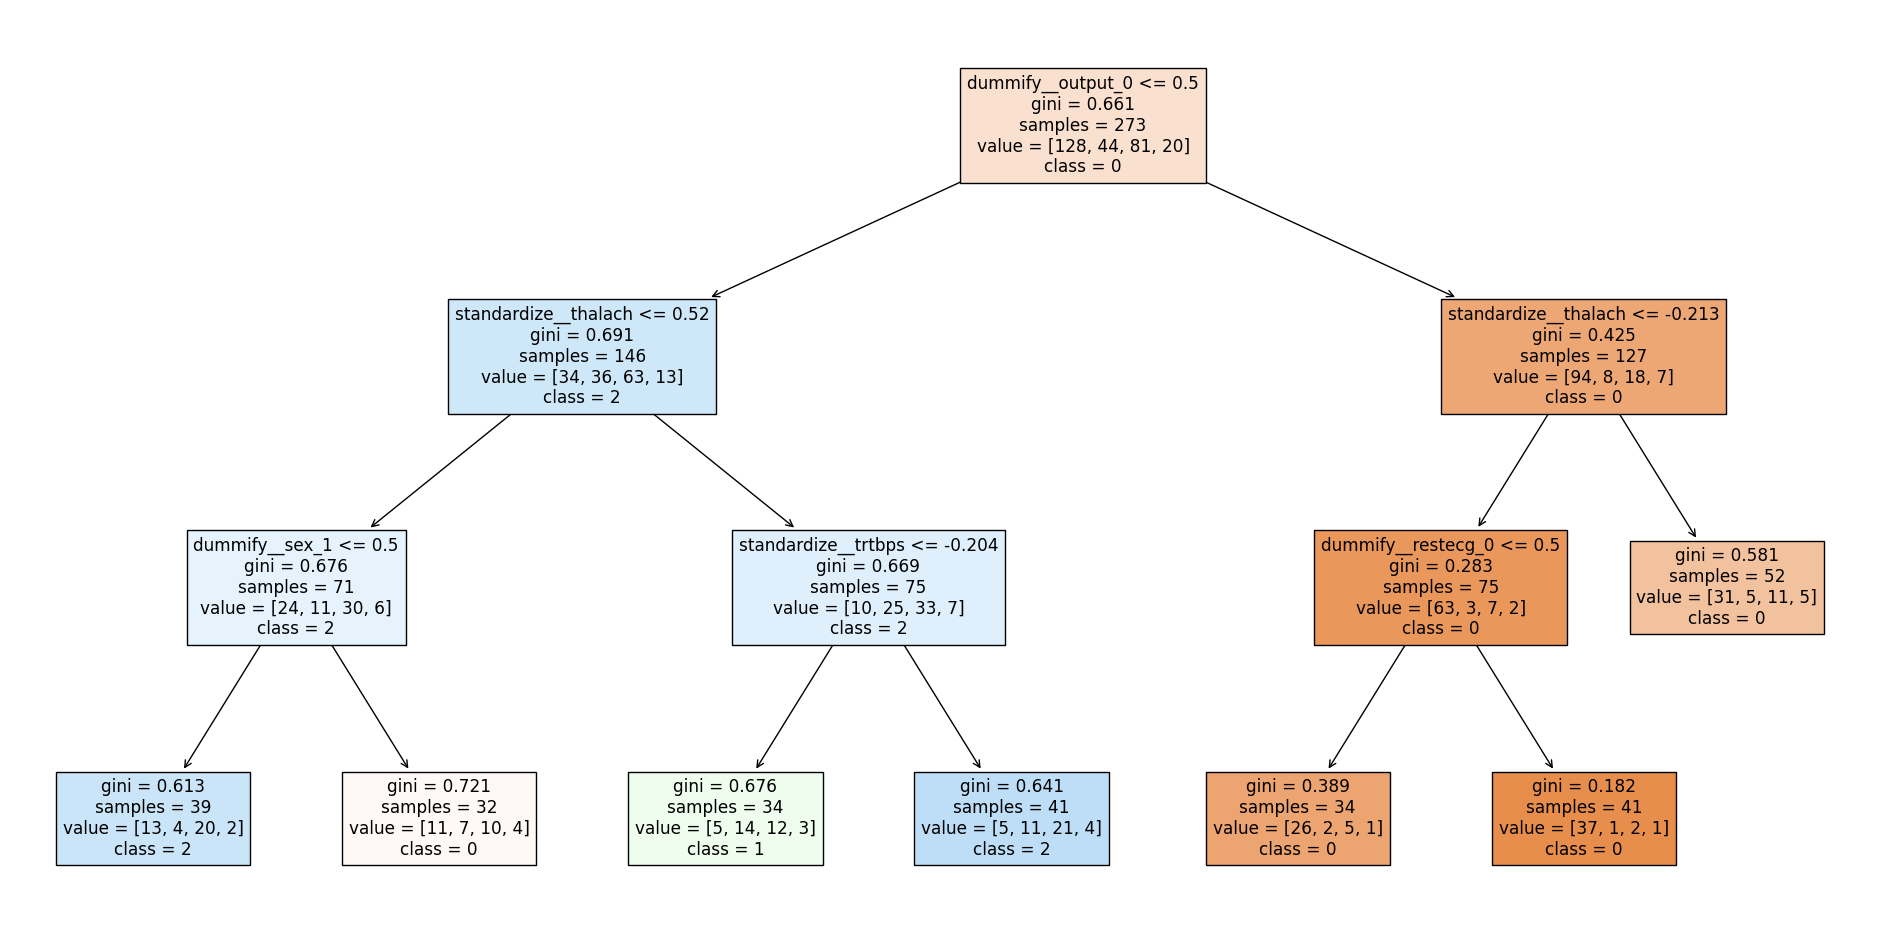

In [34]:
decisiontreePipeline = Pipeline(
  [("preprocessing", ct),
  ("dt_model", DecisionTreeClassifier(min_samples_leaf = 32))]
)

dt_model_fitted = decisiontreePipeline.fit(X,y)


plt.figure(figsize=(24, 12))  # Set the figure size

plot_tree(decisiontreePipeline.named_steps['dt_model'],
          feature_names=ct.get_feature_names_out(X.columns.tolist()).tolist(),
          class_names=['0', '1', '2', '3'],
          filled=True)
plt.show()

In [39]:
# Accuracy
dt_model_fitted.score(X, y)

0.5860805860805861

### LDA

In [38]:
LDRPipeline = Pipeline(
  [("preprocessing", ct),
  ("LDR", LinearDiscriminantAnalysis())]
)

LDR_pipeline_fitted = LDRPipeline.fit(X,y)

# Accuracy
LDR_pipeline_fitted.score(X, y)

0.5714285714285714

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

### cp_is_3

In [91]:
# cp_is_3

# reset
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha['sex'] = ha['sex'].astype(str)
ha['cp'] = ha['cp'].astype(str)
ha['restecg'] = ha['restecg'].astype(str)
ha['output'] = ha['output'].astype(str)


dummies = pd.get_dummies(ha['cp'])
ha["cp_is_3"] = dummies["3"].astype(str)

X = ha.drop(["cp_is_3", 'cp'], axis = 1) # drop bc identification variables/response variable
y = ha["cp_is_3"]

logisticPipeline = Pipeline(
  [("preprocessing", ct),
  ("logistic_regression", LogisticRegression())]
)

log_pipeline_fitted = logisticPipeline.fit(X,y)
y_pred = logisticPipeline.predict(X_test)
f1_score(y_test, y_pred, average = "micro")

0.5217391304347826

### cp_is_0

In [90]:
# reset
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha['sex'] = ha['sex'].astype(str)
ha['cp'] = ha['cp'].astype(str)
ha['restecg'] = ha['restecg'].astype(str)
ha['output'] = ha['output'].astype(str)

# cp_is_0
dummies = pd.get_dummies(ha['cp'])
ha["cp_is_0"] = dummies["0"].astype(str)

X = ha.drop(["cp_is_0", 'cp'], axis = 1) # drop bc identification variables/response variable
y = ha["cp_is_0"]

logisticPipeline = Pipeline(
  [("preprocessing", ct),
  ("logistic_regression", LogisticRegression())]
)

log_pipeline_fitted = logisticPipeline.fit(X,y)
y_pred = logisticPipeline.predict(X_test)
f1_score(y_test, y_pred, average='micro')

0.18840579710144928

### cp_is_1

In [89]:
# reset
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha['sex'] = ha['sex'].astype(str)
ha['cp'] = ha['cp'].astype(str)
ha['restecg'] = ha['restecg'].astype(str)
ha['output'] = ha['output'].astype(str)

# cp_is_1
dummies = pd.get_dummies(ha['cp'])
ha["cp_is_1"] = dummies["1"].astype(str)

X = ha.drop(["cp", "cp_is_1"], axis = 1) # drop bc identification variables/response variable
y = ha["cp_is_1"]

logisticPipeline = Pipeline(
  [("preprocessing", ct),
  ("logistic_regression", LogisticRegression())]
)

log_pipeline_fitted = logisticPipeline.fit(X,y)
y_pred = logisticPipeline.predict(X_test)
f1_score(y_test, y_pred, average='micro')

0.5217391304347826

### cp_is_2

In [88]:
# reset
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha['sex'] = ha['sex'].astype(str)
ha['cp'] = ha['cp'].astype(str)
ha['restecg'] = ha['restecg'].astype(str)
ha['output'] = ha['output'].astype(str)

# cp_is_2
dummies = pd.get_dummies(ha['cp'])
ha["cp_is_2"] = dummies["2"].astype(str)

X = ha.drop(["cp", "cp_is_2"], axis = 1) # drop bc identification variables/response variable
y = ha["cp_is_2"]

logisticPipeline = Pipeline(
  [("preprocessing", ct),
  ("logistic_regression", LogisticRegression())]
)

log_pipeline_fitted = logisticPipeline.fit(X,y)
y_pred = logisticPipeline.predict(X_test)
f1_score(y_test, y_pred, average='micro')

0.5072463768115942

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

### 0 vs 1

In [84]:
# reset
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha['sex'] = ha['sex'].astype(str)
ha['cp'] = ha['cp'].astype(str)
ha['restecg'] = ha['restecg'].astype(str)
ha['output'] = ha['output'].astype(str)

# 0 vs 1
ha03 = ha[(ha["cp"] == "0") | (ha["cp"] == "1")]

X = ha03.drop(["cp"], axis = 1) # drop bc identification variables/response variable
y = ha03["cp"]

logisticPipeline = Pipeline(
  [("preprocessing", ct),
  ("logistic_regression", LogisticRegression())]
)

logistic_model_fitted = logisticPipeline.fit(X,y)

# Final Model ROC AUC metric
y_prob = logisticPipeline.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

0.8442826704545455

### 0 vs 2

In [85]:
# reset
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha['sex'] = ha['sex'].astype(str)
ha['cp'] = ha['cp'].astype(str)
ha['restecg'] = ha['restecg'].astype(str)
ha['output'] = ha['output'].astype(str)

# 0 vs 2
ha02 = ha[(ha["cp"] == "0") | (ha["cp"] == "2")]

X = ha02.drop(["cp"], axis = 1) # drop bc identification variables/response variable
y = ha02["cp"]

logisticPipeline = Pipeline(
  [("preprocessing", ct),
  ("logistic_regression", LogisticRegression())]
)

logistic_model_fitted = logisticPipeline.fit(X,y)

# Final Model ROC AUC metric
y_prob = logisticPipeline.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

0.8080632716049382

### 0 vs 3

In [86]:
# reset
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha['sex'] = ha['sex'].astype(str)
ha['cp'] = ha['cp'].astype(str)
ha['restecg'] = ha['restecg'].astype(str)
ha['output'] = ha['output'].astype(str)

# 0 vs 3
ha03 = ha[(ha["cp"] == "0") | (ha["cp"] == "3")]

X = ha03.drop(["cp"], axis = 1) # drop bc identification variables/response variable
y = ha03["cp"]

logisticPipeline = Pipeline(
  [("preprocessing", ct),
  ("logistic_regression", LogisticRegression())]
)

logistic_model_fitted = logisticPipeline.fit(X,y)

# Final Model ROC AUC metric
y_prob = logisticPipeline.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

0.828125